## Formating Semeval Training set

In [11]:
import pandas as pd

### select appropriate file in the read_csv from semeval set

In [12]:
data=pd.read_csv('/data/nlp/semeval/SemEval2022-Task11_Train-Dev/HI-Hindi/hi_train.conll',sep=' _ _ ',engine='python',names=['Word','Tag'],encoding='UTF-8-sig').fillna(method='ffill')
data.shape

(259866, 2)

In [13]:
data=data.iloc[1:]
data.head

<bound method NDFrame.head of                Word     Tag
1       जियोर्जियोन       O
2              ०१९।       O
3            जेपीजी       O
4                 |       O
5       जियोर्जियोन       O
...             ...     ...
259861     क्वालकॉम  B-PROD
259862  स्नैपड्रैगन  I-PROD
259863            .       O
259864           के       O
259865       उदाहरण       O

[259865 rows x 2 columns]>

In [14]:
data['Tag'].value_counts()

O         224689
I-GRP       5838
I-CW        3623
B-PROD      3086
I-CORP      2927
I-PER       2867
B-GRP       2843
B-CORP      2704
B-LOC       2626
B-PER       2419
B-CW        2319
I-PROD      2308
I-LOC       1616
Name: Tag, dtype: int64

In [15]:
import re
def format_data(inputdata):
    i=0
    j=0
    df=[]
    while(i < len(inputdata['Word'])):
        senten_number="Sentence : "+str(j)
        #print(inputdata['Word'].iloc[i],i)
        pattern = '^#.*'
        result = re.match(pattern, inputdata['Word'].iloc[i])
        if result:
            tmp=[senten_number,'.','O']
            df.append(tmp)
            j=j+1
        else:
            tmp=[senten_number,inputdata['Word'].iloc[i],inputdata['Tag'].iloc[i]]
            df.append(tmp)          
        i=i+1       
    returnable_1=pd.DataFrame(df,columns=['Sentence #','Word','Tag'])
    returnable_1['POS']='NNS'
    return returnable_1

In [16]:
data_format=format_data(data)
data_format.head()

Sentence #         Word Tag  POS
0  Sentence : 0  जियोर्जियोन   O  NNS
1  Sentence : 0         ०१९।   O  NNS
2  Sentence : 0       जेपीजी   O  NNS
3  Sentence : 0            |   O  NNS
4  Sentence : 0  जियोर्जियोन   O  NNS

In [17]:
print(len(data_format['Word']))
i=0
while(i < len(data_format['Word'])):
    if(i < len(data_format['Word']) - 1):
        if((data_format['Word'].iloc[i]==data_format['Word'].iloc[i+1])&(data_format['Word'].iloc[i]=='.')):
            #print(data_format['Word'].iloc[i])
            data_format=data_format.drop(i)
    i=i+1
print(len(data_format['Word']))

259865
259728


In [18]:
data_format.to_pickle("/data/nlp/semeval/hi_file.pkl")

## Load a pickle file for existing training data

In [19]:
#load "/data/nlp/extra_data/a_file.pkl" for english data
data=pd.read_pickle("/data/nlp/semeval/hi_file.pkl")

In [20]:
class SentenceGetter(object):

    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, p, t) for w, p, t in zip(s["Word"].values.tolist(),
                                                           s["POS"].values.tolist(),
                                                           s["Tag"].values.tolist())]
        self.grouped = self.data.groupby("Sentence #").apply(agg_func)
        self.sentences = [s for s in self.grouped]

    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None


In [21]:
getter = SentenceGetter(data)
sentences = [[word[0] for word in sentence] for sentence in getter.sentences]
sentences[0]


['जियोर्जियोन',
 '०१९।',
 'जेपीजी',
 '|',
 'जियोर्जियोन',
 'आंधी',
 ',',
 '८२',
 '×',
 '७३',
 'सेमी',
 '.']

In [22]:
labels = [[s[2] for s in sentence] for sentence in getter.sentences]
print(labels[0])


['O', 'O', 'O', 'O', 'O', 'B-CW', 'O', 'O', 'O', 'O', 'O', 'O']


In [23]:
tag_values = list(set(data["Tag"].values))
print(tag_values)
tag_values.append("PAD")
print(tag_values)
tag2idx = {t: i for i, t in enumerate(tag_values)}
print(tag2idx)

['I-PROD', 'I-CORP', 'B-PER', 'B-CW', 'B-GRP', 'I-GRP', 'I-CW', 'O', 'B-PROD', 'I-PER', 'B-LOC', 'B-CORP', 'I-LOC']
['I-PROD', 'I-CORP', 'B-PER', 'B-CW', 'B-GRP', 'I-GRP', 'I-CW', 'O', 'B-PROD', 'I-PER', 'B-LOC', 'B-CORP', 'I-LOC', 'PAD']
{'I-PROD': 0, 'I-CORP': 1, 'B-PER': 2, 'B-CW': 3, 'B-GRP': 4, 'I-GRP': 5, 'I-CW': 6, 'O': 7, 'B-PROD': 8, 'I-PER': 9, 'B-LOC': 10, 'B-CORP': 11, 'I-LOC': 12, 'PAD': 13}


In [24]:
pd.unique(data['Tag'])

array(['O', 'B-CW', 'B-PROD', 'B-PER', 'I-PER', 'I-PROD', 'B-LOC',
       'B-CORP', 'I-CORP', 'B-GRP', 'I-GRP', 'I-CW', 'I-LOC'],
      dtype=object)

# Tokenizer 

In [37]:
from sklearn.metrics import confusion_matrix
import pandas as pd
import numpy as np
from tqdm import tqdm, trange
import transformers
from transformers import BertForTokenClassification, AdamW
#from pytorch_pretrained_bert import BertTokenizer, BertConfig
#from pytorch_pretrained_bert import BertAdam, BertForSequenceClassification,BertForTokenClassification

import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertConfig, GPT2Tokenizer, GPT2LMHeadModel

from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from transformers import get_linear_schedule_with_warmup
from seqeval.metrics import f1_score, accuracy_score
import matplotlib.pyplot as plt
%matplotlib inline
import json
import seaborn as sns
import os
import sys
os.environ["TFHUB_CACHE_DIR"] = '/data/tfhub_modules'

#sys.path.extend(["/home/nilesh/git/tensorflow_experiments/tf2.3/models"])
from transformers import RemBertTokenizerFast,RemBertConfig,RemBertTokenizer

In [25]:
tokenizer = RemBertTokenizerFast.from_pretrained("google/rembert")

In [26]:
def tokenize_and_preserve_labels(sentence, text_labels):
    tokenized_sentence = []
    labels = []

    for word, label in zip(sentence, text_labels):

        # Tokenize the word and count # of subwords the word is broken into
        #print(word)
        tokenized_word = tokenizer.tokenize(word)
        n_subwords = len(tokenized_word)

        # Add the tokenized word to the final tokenized word list
        tokenized_sentence.extend(tokenized_word)

        # Add the same label to the new list of labels `n_subwords` times
        labels.extend([label] * n_subwords)

    return tokenized_sentence, labels


In [27]:
tokenized_texts_and_labels = [
    tokenize_and_preserve_labels(sent, labs)
    for sent, labs in zip(sentences, labels)
]


In [28]:
tokenized_texts = [token_label_pair[0] for token_label_pair in tokenized_texts_and_labels]
labels = [token_label_pair[1] for token_label_pair in tokenized_texts_and_labels]


In [29]:
MAX_LEN = 75
#MAX_LEN = 128
bs = 16#32


In [32]:
input_ids = pad_sequences([tokenizer.convert_tokens_to_ids(txt) for txt in tokenized_texts],
                          maxlen=MAX_LEN, dtype="long", value=0.0,
                          truncating="post", padding="post")


In [33]:
tags = pad_sequences([[tag2idx.get(l) for l in lab] for lab in labels],
                     maxlen=MAX_LEN, value=tag2idx["PAD"], padding="post",
                     dtype="long", truncating="post")


In [34]:
attention_masks = [[float(i != 0.0) for i in ii] for ii in input_ids]


In [35]:
np.array(np.unique(tags, return_counts=True)).T

array([[     0,   4529],
       [     1,   6574],
       [     2,   6198],
       [     3,   5459],
       [     4,   6972],
       [     5,  11347],
       [     6,   6532],
       [     7, 342473],
       [     8,   8046],
       [     9,   8093],
       [    10,   7935],
       [    11,   7238],
       [    12,   3200],
       [    13, 732429]])

In [38]:
tr_inputs, val_inputs, tr_tags, val_tags = train_test_split(input_ids, tags,random_state=2018, test_size=0.1)#,stratify=tags)
tr_masks, val_masks, _, _ = train_test_split(attention_masks, input_ids,random_state=2018, test_size=0.1)#,stratify=input_ids)


In [39]:
tr_inputs = torch.tensor(tr_inputs)
val_inputs = torch.tensor(val_inputs)
tr_tags = torch.tensor(tr_tags)
val_tags = torch.tensor(val_tags)
tr_masks = torch.tensor(tr_masks)
val_masks = torch.tensor(val_masks)


In [40]:
train_data = TensorDataset(tr_inputs, tr_masks, tr_tags)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=bs)

valid_data = TensorDataset(val_inputs, val_masks, val_tags)
valid_sampler = SequentialSampler(valid_data)
valid_dataloader = DataLoader(valid_data, sampler=valid_sampler, batch_size=bs)


In [41]:
args_do_lower_case='False'
#args_do_lower_case='True'
args_max_seq_length=128
num_labels=len(tag2idx)
args_bert_model='google/rembert'
#from torch.utils.data import DataLoader
from transformers import RemBertForTokenClassification,DistilBertForTokenClassification, AdamW,RemBertForSequenceClassification

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model = RemBertForTokenClassification.from_pretrained(args_bert_model, num_labels=num_labels,
   output_attentions = False,
   output_hidden_states = False
)



Some weights of the model checkpoint at google/rembert were not used when initializing RemBertForTokenClassification: ['pooler.dense.bias', 'pooler.dense.weight']
- This IS expected if you are initializing RemBertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RemBertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RemBertForTokenClassification were not initialized from the model checkpoint at google/rembert and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [42]:
model.cuda()


RemBertForTokenClassification(
  (rembert): RemBertModel(
    (embeddings): RemBertEmbeddings(
      (word_embeddings): Embedding(250300, 256, padding_idx=0)
      (position_embeddings): Embedding(512, 256)
      (token_type_embeddings): Embedding(2, 256)
      (LayerNorm): LayerNorm((256,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0, inplace=False)
    )
    (encoder): RemBertEncoder(
      (embedding_hidden_mapping_in): Linear(in_features=256, out_features=1152, bias=True)
      (layer): ModuleList(
        (0): RemBertLayer(
          (attention): RemBertAttention(
            (self): RemBertSelfAttention(
              (query): Linear(in_features=1152, out_features=1152, bias=True)
              (key): Linear(in_features=1152, out_features=1152, bias=True)
              (value): Linear(in_features=1152, out_features=1152, bias=True)
              (dropout): Dropout(p=0, inplace=False)
            )
            (output): RemBertSelfOutput(
              (dense)

In [43]:
FULL_FINETUNING = True
if FULL_FINETUNING:
    param_optimizer = list(model.named_parameters())
    no_decay = ['bias', 'gamma', 'beta']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.01},
        {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.0}
    ]
else:
    param_optimizer = list(model.classifier.named_parameters())
    optimizer_grouped_parameters = [{"params": [p for n, p in param_optimizer]}]

optimizer = AdamW(optimizer_grouped_parameters,lr=3e-5,eps=1e-8)
#optimizer = BertAdam(optimizer_grouped_parameters,lr=2e-5,warmup=.1)

In [44]:


epochs = 3
max_grad_norm = 1.0

# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)


In [45]:
## Store the average loss after each epoch so we can plot them.
loss_values, validation_loss_values = [], []

for _ in trange(epochs, desc="Epoch"):
    # ========================================
    #               Training
    # ========================================
    # Perform one full pass over the training set.

    # Put the model into training mode.
    model.train()
    # Reset the total loss for this epoch.
    total_loss = 0

    # Training loop
    for step, batch in enumerate(train_dataloader):
        # add batch to gpu
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        # Always clear any previously calculated gradients before performing a backward pass.
        model.zero_grad()
        # forward pass
        # This will return the loss (rather than the model output)
        # because we have provided the `labels`.
        ##
        outputs = model(b_input_ids, token_type_ids=None,attention_mask=b_input_mask, labels=b_labels)
        #outputs = model(b_input_ids, token_type_ids=None,attention_mask=b_input_mask)#outputs = model(**inputs)
        # get the loss
        loss = outputs[0]#loss = outputs[0]
        # Perform a backward pass to calculate the gradients.
        loss.backward()
        # track train loss
        total_loss += loss.item()
        # Clip the norm of the gradient
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(parameters=model.parameters(), max_norm=max_grad_norm)
        # update parameters
        optimizer.step()
        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over the training data.
    avg_train_loss = total_loss / len(train_dataloader)
    print("Average train loss: {}".format(avg_train_loss))

    # Store the loss value for plotting the learning curve.
    loss_values.append(avg_train_loss)


    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    # Put the model into evaluation mode
    model.eval()
    # Reset the validation loss for this epoch.
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0
    predictions , true_labels = [], []
    for batch in valid_dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch

        # Telling the model not to compute or store gradients,
        # saving memory and speeding up validation
        with torch.no_grad():
            # Forward pass, calculate logit predictions.
            # This will return the logits rather than the loss because we have not provided labels.
            outputs = model(b_input_ids, token_type_ids=None,
                            attention_mask=b_input_mask, labels=b_labels)
        # Move logits and labels to CPU
        logits = outputs[1].detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences.
        eval_loss += outputs[0].mean().item()
        predictions.extend([list(p) for p in np.argmax(logits, axis=2)])
        true_labels.extend(label_ids)

    eval_loss = eval_loss / len(valid_dataloader)
    validation_loss_values.append(eval_loss)
    print("Validation loss: {}".format(eval_loss))
    pred_tags = [tag_values[p_i] for p, l in zip(predictions, true_labels)
                                 for p_i, l_i in zip(p, l) if tag_values[l_i] != "PAD"]
    valid_tags = [tag_values[l_i] for l in true_labels
                                  for l_i in l if tag_values[l_i] != "PAD"]
    print("Validation Accuracy: {}".format(accuracy_score(pred_tags, valid_tags)))
    #print("Validation F1-Score: {}".format(f1_score(pred_tags, valid_tags)))
    print()


Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Average train loss: 0.3533224960711832


Epoch:  33%|███▎      | 1/3 [07:30<15:01, 450.68s/it]

Validation loss: 0.2672503986155864
Validation Accuracy: 0.9169661522561248

Average train loss: 0.15605815566114842


Epoch:  67%|██████▋   | 2/3 [15:01<07:30, 450.82s/it]

Validation loss: 0.2089800612674546
Validation Accuracy: 0.937025814483358

Average train loss: 0.06375395927056755


Epoch: 100%|██████████| 3/3 [22:31<00:00, 450.61s/it]

Validation loss: 0.22598394511517175
Validation Accuracy: 0.9445423155521105



In [47]:
from sklearn.metrics import classification_report
y_true = valid_tags
y_pred = pred_tags
target_names = list(set(valid_tags))
print(classification_report(y_true, y_pred, target_names=target_names))

              precision    recall  f1-score   support

      I-PROD       0.76      0.73      0.75       728
      I-CORP       0.64      0.57      0.60       547
       B-PER       0.75      0.74      0.75       688
       I-GRP       0.82      0.83      0.83       766
       B-GRP       0.84      0.91      0.87       589
        B-CW       0.76      0.71      0.74       914
        I-CW       0.80      0.77      0.78       615
           O       0.75      0.66      0.70       691
      B-PROD       0.86      0.81      0.84      1128
       I-PER       0.77      0.80      0.79       370
      B-CORP       0.88      0.94      0.91       761
       B-LOC       0.76      0.70      0.73       496
       I-LOC       0.98      0.99      0.98     34280

    accuracy                           0.94     42573
   macro avg       0.80      0.78      0.79     42573
weighted avg       0.94      0.94      0.94     42573



In [48]:
print(len(valid_tags))
print(len(pred_tags))

42573
42573


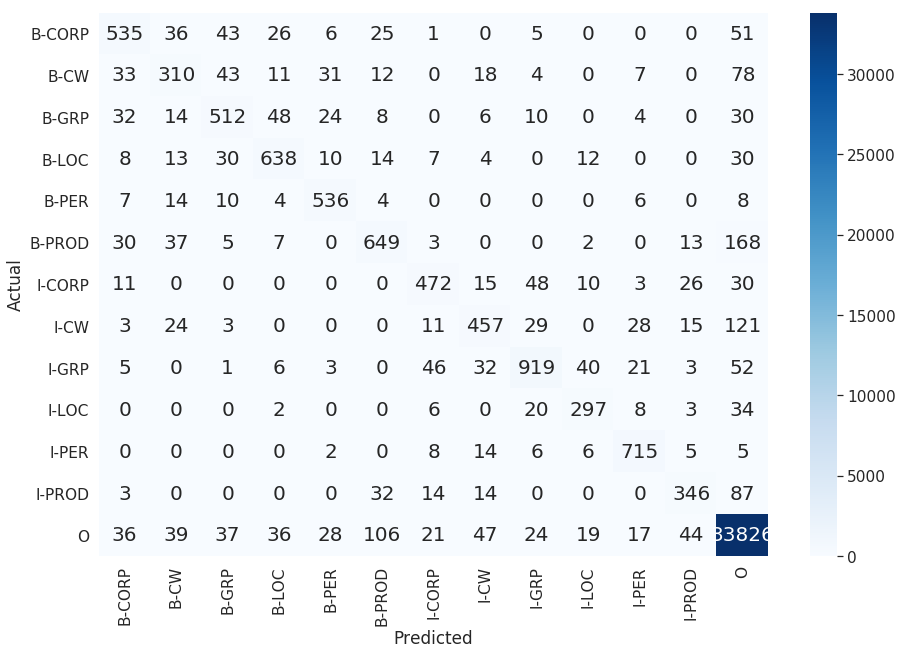

In [49]:
#y_true = ["honda", "chevrolet", "honda", "toyota", "toyota", "chevrolet"]
#y_pred = ["honda", "chevrolet", "honda", "toyota", "toyota", "honda"]
data_cf = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(data_cf, columns=np.unique(y_true), index = np.unique(y_true))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (15,10))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, cmap="Blues", annot=True, fmt='g',annot_kws={"size": 20})# font size

# testing the above model manually

In [50]:
test_sentence0='all songs written by m.o.d. unless otherwise stated'
test_sentence1 = 'adaptation of the manga series by chiho saito.'
test_sentence2 ='he was also the inventor of the nerf football.'
test_sentence3='इस्लामिक सहकारिता का संगठन के ५वें महासचिव के रूप में भी कार्य किया। '
test_sentence=test_sentence3

In [51]:
tokenized_sentence = tokenizer.encode(test_sentence)
print(tokenized_sentence)
input_ids = torch.tensor([tokenized_sentence]).cuda()


[312, 135699, 3890, 161024, 35260, 1257, 76232, 847, 19709, 81217, 13317, 225664, 847, 5603, 969, 2422, 12264, 3239, 661, 573, 313]


In [52]:
with torch.no_grad():
    output = model(input_ids)
label_indices = np.argmax(output[0].to('cpu').numpy(), axis=2)


In [53]:
# join bpe split tokens
tokens = tokenizer.convert_ids_to_tokens(input_ids.to('cpu').numpy()[0])
new_tokens, new_labels = [], []
for token, label_idx in zip(tokens, label_indices[0]):
    if token.startswith("##"):
        new_tokens[-1] = new_tokens[-1] + token[2:]
    else:
        new_labels.append(tag_values[label_idx])
        new_tokens.append(token)
output = [{"word":token,"tag":label} for token, label in zip(new_tokens, new_labels)]

In [54]:
lst_tuple=output

lst_tuple_1= [(x['tag']!='O') for x in lst_tuple]
arr = np.array(lst_tuple)
print("input sentence:",test_sentence,"Entity:",arr[lst_tuple_1])

input sentence: इस्लामिक सहकारिता का संगठन के ५वें महासचिव के रूप में भी कार्य किया।  Entity: [{'word': '▁इस्लाम', 'tag': 'B-GRP'} {'word': 'िक', 'tag': 'B-GRP'}
 {'word': '▁सहकार', 'tag': 'I-GRP'} {'word': 'िता', 'tag': 'I-GRP'}
 {'word': '▁का', 'tag': 'I-GRP'} {'word': '▁संगठन', 'tag': 'I-GRP'}]


# SAVE the model

## Saving the model and testing against set note:make sure to change the path

In [ ]:
# Save a trained model and the associated configuration
final_model_path='/data/nlp/semeval'
final_versioned_model_path = os.path.join(final_model_path,'en')
model_to_save = model.module if hasattr(model, 'module') else model  # Only save the model it-self
model_to_save.save_pretrained(final_versioned_model_path)
tokenizer.save_pretrained(final_versioned_model_path)
#label_map = {i : label for i, label in enumerate(label_list,1)}
model_config = {"bert_model":args_bert_model,"do_lower":args_do_lower_case,"max_seq_length":args_max_seq_length,"num_labels":num_labels,"label_map":tag2idx}
json.dump(model_config,open(os.path.join(final_versioned_model_path,"model_config.json"),"w"))

### load a stored model

In [1]:
from transformers import RemBertForTokenClassification,RemBertForSequenceClassification
from transformers import RemBertTokenizerFast,RemBertConfig,RemBertTokenizer
import os,json
import torch
import numpy as np

In [2]:
class Ner:

    def __init__(self,model_dir: str):
        self.model , self.tokenizer, self.model_config = self.load_model(model_dir)
        self.label_map = self.model_config["label_map"]
        self.max_seq_length = self.model_config["max_seq_length"]
        self.label_map = {int(v):k for k,v in self.label_map.items()}
        self.device = "cuda:0" if torch.cuda.is_available() else "cpu"
        self.model = self.model.to(self.device)
        self.model.eval()

    def load_model(self, model_dir: str, model_config: str = "model_config.json"):
        model_config = os.path.join(model_dir,model_config)
        model_config = json.load(open(model_config))
        model = RemBertForTokenClassification.from_pretrained(model_dir)
        tokenizer = RemBertTokenizerFast.from_pretrained(model_dir, do_lower_case=model_config["do_lower"])
        return model, tokenizer, model_config

    def tokenize(self, text: str):
        """ tokenize input"""
        tokenized_sentence = self.tokenizer.encode(text)
        return tokenized_sentence

    def preprocess(self, text: str):
       
        """ preprocess """
        tokenized_sentence = self.tokenize(text)
        input_ids = torch.tensor([tokenized_sentence])
        input_ids = input_ids.to(self.device)
        return input_ids

    def predict(self, text: str):
        input_ids = self.preprocess(text)
        with torch.no_grad():
            output = self.model(input_ids)
        label_indices = np.argmax(output[0].to('cpu').numpy(), axis=2)
        
        tokens = self.tokenizer.convert_ids_to_tokens(input_ids.to('cpu').numpy()[0])
        new_tokens, new_labels = [], []
        for token, label_idx in zip(tokens, label_indices[0]):
            if token.startswith("##"):
                new_tokens[-1] = new_tokens[-1] + token[2:]
            else:
                new_labels.append(self.label_map[label_idx])
                new_tokens.append(token)
        output = [{"word":token,"tag":label} for token, label in zip(new_tokens, new_labels)]
        return output
    
    def get_turn_output(self, input_list):
        lst_tuple = [self.predict(x) for x in input_list]
        lst_tuple1=[]
        for i in range(len(lst_tuple)):
            lst_tuple_1= [(x['tag']!='O') for x in lst_tuple[i]]
            arr = np.array(lst_tuple[i])
            lst_tuple1.append(arr[lst_tuple_1])
        output = [{"Sentence":token,"Entity":label} for token, label in zip(amount, lst_tuple1)]
        return output 



In [3]:
final_versioned_model_path='/data/nlp/semeval/en/'
model = Ner(final_versioned_model_path)

In [4]:
test_sentence="he was also the inventor of the nerf football."

In [5]:
check=model.predict(test_sentence)

In [6]:
print(check)

[{'word': '[CLS]', 'tag': 'O'}, {'word': '▁he', 'tag': 'O'}, {'word': '▁was', 'tag': 'O'}, {'word': '▁also', 'tag': 'O'}, {'word': '▁the', 'tag': 'O'}, {'word': '▁inventor', 'tag': 'O'}, {'word': '▁of', 'tag': 'O'}, {'word': '▁the', 'tag': 'O'}, {'word': '▁ne', 'tag': 'B-PROD'}, {'word': 'rf', 'tag': 'B-PROD'}, {'word': '▁football', 'tag': 'I-PROD'}, {'word': '.', 'tag': 'O'}, {'word': '[SEP]', 'tag': 'O'}]


In [7]:
lst_tuple=[model.predict(test_sentence)]

In [8]:
lst_tuple1=[]
for i in range(len(lst_tuple)):
    lst_tuple_1= [(x['tag']!='O') for x in lst_tuple[i]]
    arr = np.array(lst_tuple[i])
    lst_tuple1.append(arr[lst_tuple_1])

In [9]:
print("Sentence:",test_sentence,"\n","Entity:",lst_tuple1)

Sentence: he was also the inventor of the nerf football. 
 Entity: [array([{'word': '▁ne', 'tag': 'B-PROD'}, {'word': 'rf', 'tag': 'B-PROD'},
       {'word': '▁football', 'tag': 'I-PROD'}], dtype=object)]
